# Cinema Compass: Navigating Scores and Recommendations
### By Hayal AHLAT

## Introduction

Movies have always fascinated me—not just as a form of entertainment but as a reflection of storytelling, culture, and human emotions.  
I embarked on this project to delve deeper into what makes some movies highly rated and others less so.  
Through this analysis, I aim to:  
1. Understand patterns in movie ratings.  
2. Learn how different features (e.g., genres, language, popularity) impact scores.  
3. Improve my skills in data analysis, visualization, and machine learning.  

This exploration will not only help me build predictive models for movie ratings but also provide insights into the characteristics of successful films.


## Step 0: Import Libraries

In [2]:
#!pip install wordcloud

In [3]:
#!pip install lightgbm


In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import plotly.express as px
from wordcloud import WordCloud
import ipywidgets as widgets
from ipywidgets import interact
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import pickle

## Step 1: Load the Data and Data Processing

In [5]:
movies=pd.read_csv('Movies.csv')

In [6]:
movies.head()

id                        title                 genre original_language  \
0    278     The Shawshank Redemption           Drama,Crime                en   
1  19404  Dilwale Dulhania Le Jayenge  Comedy,Drama,Romance                hi   
2    238                The Godfather           Drama,Crime                en   
3    424             Schindler's List     Drama,History,War                en   
4    240       The Godfather: Part II           Drama,Crime                en   

                                            overview  popularity release_date  \
0  Framed in the 1940s for the double murder of h...      94.075   1994-09-23   
1  Raj is a rich, carefree, happy-go-lucky second...      25.408   1995-10-19   
2  Spanning the years 1945 to 1955, a chronicle o...      90.585   1972-03-14   
3  The true story of how businessman Oskar Schind...      44.761   1993-12-15   
4  In the continuing saga of the Corleone crime f...      57.749   1974-12-20   

   vote_average  vote_count  
0           8.7       21862  
1           8.7        3731  
2           8.7       16280  
3           8.6       12959  
4           8.6        9811

In [7]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 10000 non-null  int64  
 1   title              10000 non-null  object 
 2   genre              9997 non-null   object 
 3   original_language  10000 non-null  object 
 4   overview           9987 non-null   object 
 5   popularity         10000 non-null  float64
 6   release_date       10000 non-null  object 
 7   vote_average       10000 non-null  float64
 8   vote_count         10000 non-null  int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 703.2+ KB


In [8]:
movies.describe()

id    popularity  vote_average    vote_count
count   10000.000000  10000.000000  10000.000000  10000.000000
mean   161243.505000     34.697267      6.621150   1547.309400
std    211422.046043    211.684175      0.766231   2648.295789
min         5.000000      0.600000      4.600000    200.000000
25%     10127.750000      9.154750      6.100000    315.000000
50%     30002.500000     13.637500      6.600000    583.500000
75%    310133.500000     25.651250      7.200000   1460.000000
max    934761.000000  10436.917000      8.700000  31917.000000

In [9]:
movies.isnull().sum()

id                    0
title                 0
genre                 3
original_language     0
overview             13
popularity            0
release_date          0
vote_average          0
vote_count            0
dtype: int64

The dataset contains information about movies, including titles, genres, ratings, popularity, and more.  
We start by loading the data and inspecting its structure.


## Step 2: Exploratory Data Analysis (EDA)

To understand our dataset better, we examine key statistics and visualizations. This includes:  
1. Identifying top-rated and lowest-rated movies.  
2. Analyzing genre distributions.  
3. Exploring trends over time and correlations.  


### 1. Top 10 and Bottom 10 Movies by Ratings

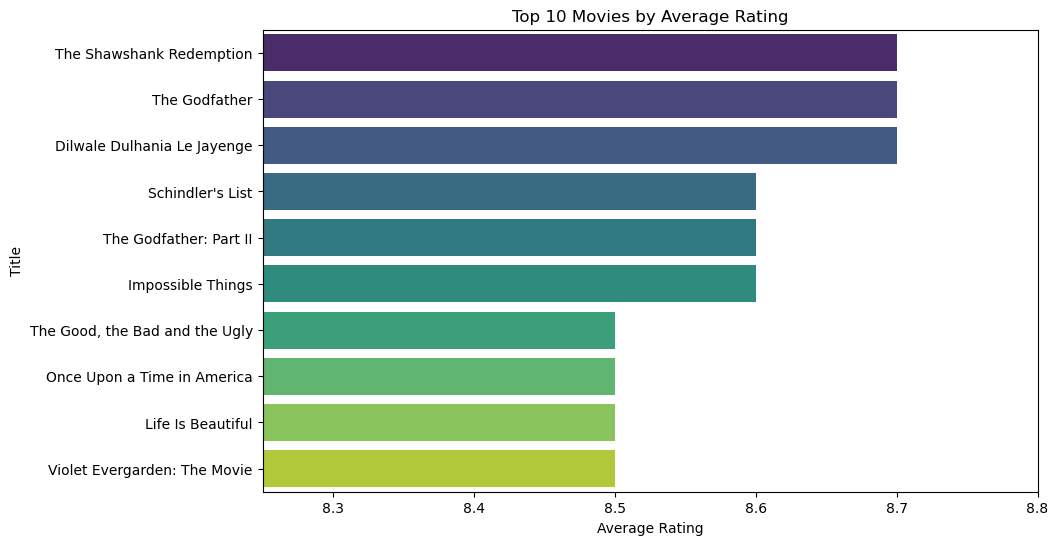

In [13]:
top_movies = movies.sort_values(by='vote_average', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='vote_average', y='title', data=top_movies, palette='viridis')
plt.title('Top 10 Movies by Average Rating')
plt.xlabel('Average Rating')
plt.ylabel('Title')
plt.xlim(8.25, 8.8)
plt.show()


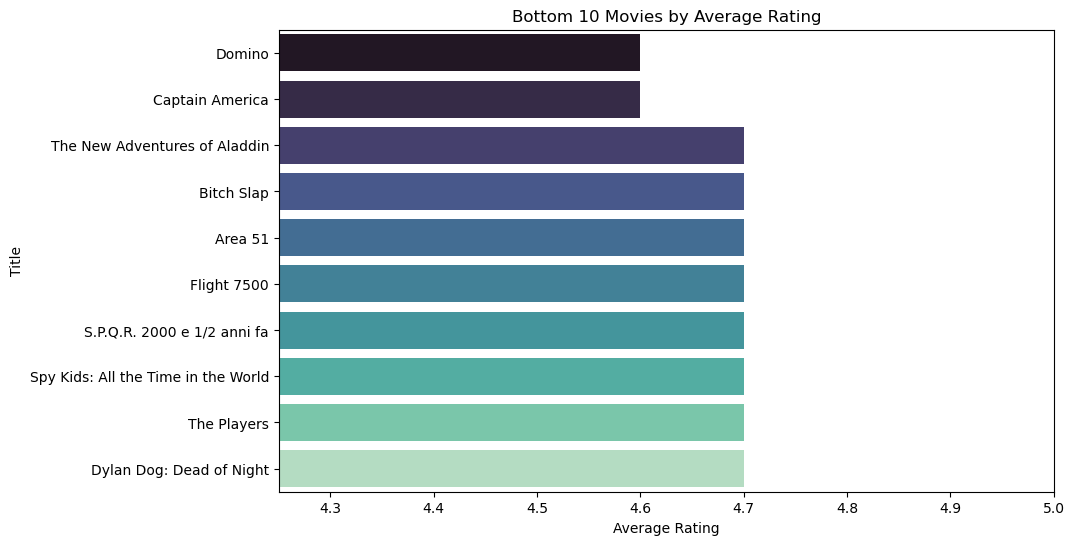

In [15]:
bottom_movies = movies.sort_values(by='vote_average', ascending=True).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x='vote_average', y='title', data=bottom_movies, palette='mako')
plt.title('Bottom 10 Movies by Average Rating')
plt.xlabel('Average Rating')
plt.ylabel('Title')
plt.xlim(4.25, 5)
plt.show()


##### Top and Bottom Movies  

The bar charts show the top 10 and bottom 10 movies based on their average ratings. This helps identify highly acclaimed movies and those that may have been poorly received.


In [16]:
top_movies = movies.sort_values(by='vote_average', ascending=False).head(50)

fig = px.bar(
    top_movies,
    x='vote_average',
    y='title',
    orientation='h',
    title='Top Films by Average Rating',
    labels={'vote_average': 'Average Rating', 'title': 'Title'},
    color='vote_average', 
    color_continuous_scale='Viridis'
)

fig.update_layout(
    yaxis=dict(categoryorder='total ascending'),
    template='plotly_white', 
    height=800  
)

fig.show()


### 2. Genre Distribution

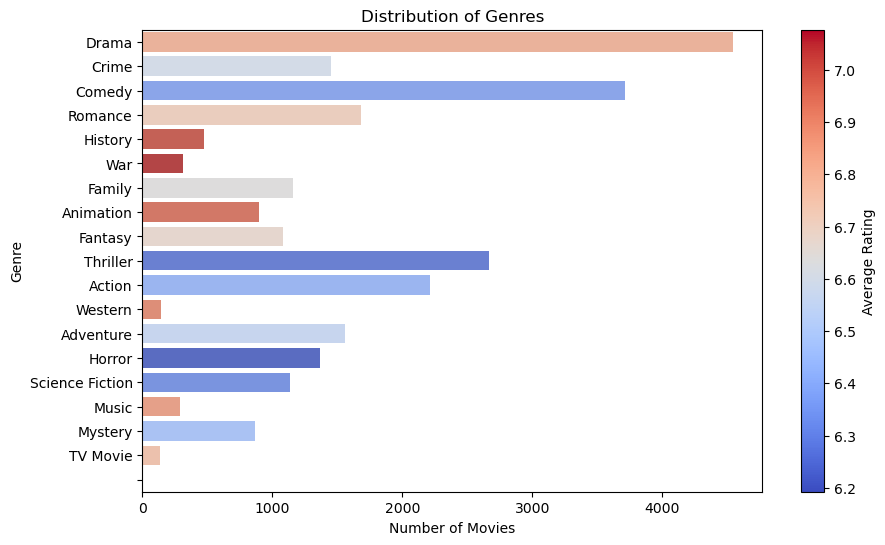

In [21]:
movies['genre'] = movies['genre'].fillna('').astype(str)
genres = movies['genre'].str.split(',').sum()
genre_counts = Counter(genres)
genre_df = pd.DataFrame(genre_counts.items(), columns=['Genre', 'Count'])

genre_df['vote_average'] = genre_df['Genre'].apply(
    lambda genre: movies[movies['genre'].str.contains(genre)]['vote_average'].mean()
)

plt.figure(figsize=(10, 6))
sns.barplot(x='Count', y='Genre', data=genre_df, palette='coolwarm', hue='vote_average', dodge=False)

plt.title('Distribution of Genres')
plt.xlabel('Number of Movies')
plt.ylabel('Genre')

sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=genre_df['vote_average'].min(), vmax=genre_df['vote_average'].max()))
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Average Rating')
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.tick_params(labelsize=10)

plt.legend([], [], frameon=False)

plt.show()

This observation may suggest that the presence of a genre in the top 10 does not necessarily correlate with a higher rating. It implies that genres like Comedy, while popular, might be subject to lower ratings on average, possibly due to viewer expectations or the subjective nature of humor. Additionally, it is possible that audiences who watch genres like Thriller or especially Comedy tend to be more critical and have higher expectations, which could contribute to the lower ratings for these films.

On the other hand, genres like War, despite being less frequent in the top 10, seem to consistently receive higher ratings. This difference in ratings could be an interesting factor to explore in a machine learning project focused on identifying what influences movie review scores.

### 3. Trends Over Time

#### 3.1 Number of Movies Released Over Time

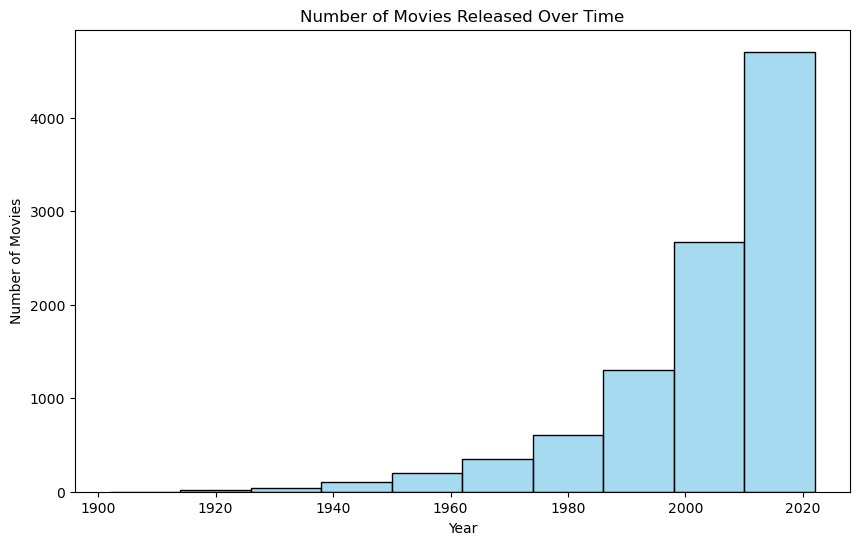

In [22]:
movies['release_year'] = pd.to_datetime(movies['release_date']).dt.year

plt.figure(figsize=(10, 6))
sns.histplot(movies['release_year'], bins=10, kde=False, color='skyblue')
plt.title('Number of Movies Released Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.show()

In this analysis of the top 10,000 films, we observe that more recent films are more prominently represented in the database compared to older films. This trend may be attributed to the relatively recent emergence of review platforms. As these platforms have only been around for a short period, they naturally feature a higher number of newer films that have received reviews and ratings.

#### 3.2 Average Popularity by Decade

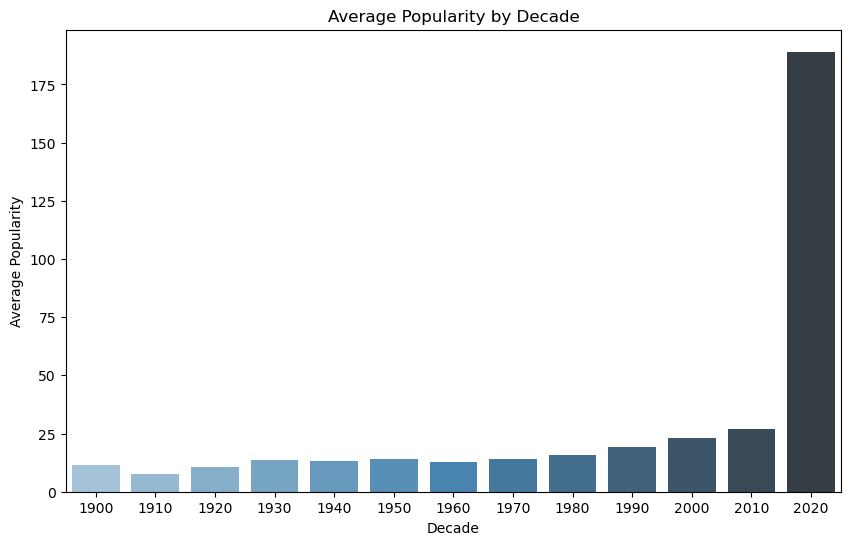

In [23]:
movies['decade'] = (movies['release_year'] // 10) * 10

decade_popularity = movies.groupby('decade')['popularity'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='decade', y='popularity', data=decade_popularity, palette='Blues_d')
plt.title('Average Popularity by Decade')
plt.xlabel('Decade')
plt.ylabel('Average Popularity')
plt.show()


Additionally, over time, the number of cinemas has increased, and access to movies has become more widespread. This increased availability could explain why recent films are generally more popular, leading to more reviews and higher representation in the database.

### 4. Impact of Popularity and The Number of votes on Movie Ratings Across Different Languages
I would now like to explore the impact of a film's popularity on its rating, specifically looking at this relationship across all the original languages of the films.

In [26]:
min_popularity = movies['popularity'].min()
max_popularity = movies['popularity'].max()

print(f'Minimum popularity value: {min_popularity}')
print(f'Maximum popularity value: {max_popularity}')


Minimum popularity value: 0.6
Maximum popularity value: 10436.917


#### 4.1 English movies

In [39]:
movies_en = movies[movies['original_language'] == 'en']

fig = px.scatter(
    movies_en,
    x='popularity',
    y='vote_average',
    size='vote_count',
    color='original_language',
    hover_name='title', 
    size_max=50,
    color_discrete_sequence=['#636EFA'], 
    title="Popularity vs. Average Rating (Language: English)",
    labels={'popularity': 'Popularity', 'vote_average': 'Average Rating'}
)

fig.show()


Let's delete the outliers to be more precise !

In [40]:
movies_en = movies[movies['original_language'] == 'en']
movies_en = movies_en[movies_en['popularity'] <= 500]

fig = px.scatter(
    movies_en,
    x='popularity',
    y='vote_average',
    size='vote_count',
    color='original_language',
    hover_name='title', 
    size_max=50,
    color_discrete_sequence=['#636EFA'],
    title="Popularity vs. Average Rating (Language: English)",
    labels={'popularity': 'Popularity', 'vote_average': 'Average Rating'}
)

fig.show()

Impact of Popularity on Movie Ratings :

What we observe here is both logical and interesting. The more popular a film is (i.e., the higher the number of viewers or entries), the higher its rating tends to be. This is especially evident with films that have close to 500 in popularity. This could suggest that as more people see positive reviews, they are more likely to watch the film and leave positive feedback themselves, creating a cycle of increasing ratings.

We also see that the larger the rating point, meaning the more votes a film has received, the higher the likelihood it will have a better rating. This could indicate that it’s primarily those who enjoyed the film who are more inclined to leave a rating, reinforcing the trend of positive feedback.

In [31]:
movies['original_language'].unique()

array(['en', 'hi', 'es', 'ja', 'ko', 'it', 'pt', 'ru', 'zh', 'fr', 'tr',
       'sv', 'ar', 'de', 'bn', 'cn', 'da', 'nl', 'th', 'fa', 'hu', 'pl',
       'sh', 'sr', 'et', 'id', 'no', 'cs', 'te', 'ro', 'bs', 'el', 'fi',
       'is', 'ml', 'la', 'af', 'uk', 'eu', 'nb', 'he', 'ab', 'xx'],
      dtype=object)

#### 4.2 Other Regions Movies

In [41]:
language_to_continent = {
    'en': 'North America', 'hi': 'India', 'es': 'Europe', 'ja': 'Asia', 'ko': 'Asia', 'it': 'Europe',
    'pt': 'South America', 'ru': 'Europe', 'zh': 'Asia', 'fr': 'Europe', 'tr': 'Asia', 'sv': 'Europe',
    'ar': 'Asia', 'de': 'Europe', 'bn': 'Asia', 'cn': 'Asia', 'da': 'Europe', 'nl': 'Europe', 'th': 'Asia',
    'fa': 'Asia', 'hu': 'Europe', 'pl': 'Europe', 'sh': 'Europe', 'sr': 'Europe', 'et': 'Europe', 'id': 'Asia',
    'no': 'Europe', 'cs': 'Europe', 'te': 'India', 'ro': 'Europe', 'bs': 'Europe', 'el': 'Europe', 'fi': 'Europe',
    'is': 'Europe', 'ml': 'India', 'la': 'Europe', 'af': 'Africa', 'uk': 'Europe', 'eu': 'Europe', 'nb': 'Europe',
    'he': 'Asia', 'ab': 'Europe', 'xx': 'Other'
}
movies_en = movies[movies['original_language'] != 'en']
movies_en = movies_en[movies_en['popularity'] <= 200]
movies_en['region'] = movies_en['original_language'].map(language_to_continent)


fig = px.scatter(
    movies_en,
    x='popularity',
    y='vote_average',
    size='vote_count',
    color='region', 
    hover_name='title',
    size_max=50,
    title="Popularity vs. Average Rating (Grouped by Region)",
    labels={'popularity': 'Popularity', 'vote_average': 'Average Rating'},
    color_discrete_map={
        'North America': '#636EFA', 'Asia': '#EF553B', 'Europe': '#00CC96', 'South America': '#FECB52',
        'Africa': '#AB63FA', 'India': '#FF97FF', 'Other': '#FFA15C'
    }
)

fig.show()

What we observe here is both logical and interesting. The more popular a film is (i.e., the higher the number of viewers or entries), the higher its rating tends to be. This is especially evident with films that have close to 500 in popularity. This could suggest that as more people see positive reviews, they are more likely to watch the film and leave positive feedback themselves, creating a cycle of increasing ratings.

We also see that the larger the rating point, meaning the more votes a film has received, the higher the likelihood it will have a better rating. This could indicate that it’s primarily those who enjoyed the film who are more inclined to leave a rating, reinforcing the trend of positive feedback.



### 5. Corrélation entre les variables

In [90]:
movies['genre'] = movies['genre'].fillna('')
unique_genres = unique_genres[unique_genres != None]
#movies['genre'] = movies['genre'].astype(str)
genres = movies['genre'].str.split(',', expand=True)

unique_genres = pd.unique(genres.values.ravel())
unique_genres = unique_genres[unique_genres != '']
unique_genres = unique_genres[unique_genres != None]
unique_genres

array(['Drama', 'Crime', 'Comedy', 'Romance', 'History', 'War', 'Family',
       'Animation', 'Fantasy', 'Thriller', 'Action', 'Western',
       'Adventure', 'Horror', 'Science Fiction', 'Music', 'Mystery',
       'TV Movie'], dtype=object)

In [91]:
for genre in unique_genres:
    movies[genre] = movies['genre'].apply(lambda x: 1 if genre in x else 0)
    
print(movies)

          id                                          title  \
0        278                       The Shawshank Redemption   
1      19404                    Dilwale Dulhania Le Jayenge   
2        238                                  The Godfather   
3        424                               Schindler's List   
4        240                         The Godfather: Part II   
...      ...                                            ...   
9995   10196                             The Last Airbender   
9996  331446                       Sharknado 3: Oh Hell No!   
9997   13995                                Captain America   
9998    2312  In the Name of the King: A Dungeon Siege Tale   
9999  455957                                         Domino   

                                                 genre original_language  \
0                                          Drama,Crime                en   
1                                 Comedy,Drama,Romance                hi   
2              

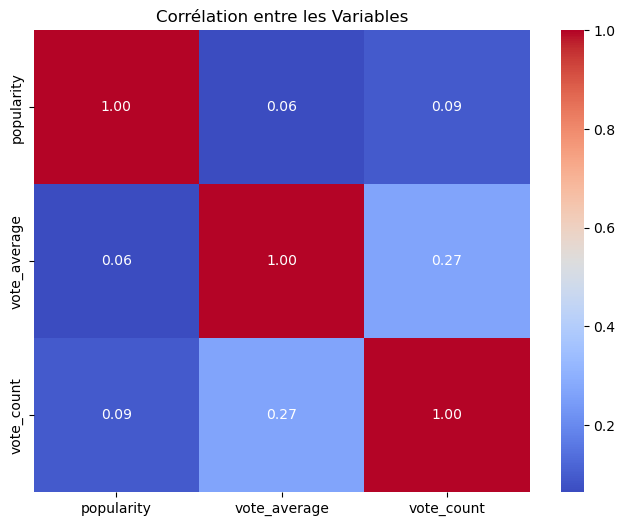

In [92]:
corr_matrix = movies[['popularity', 'vote_average', 'vote_count']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Corrélation entre les Variables') #commente
plt.show()

C:\Users\bync\AppData\Local\Temp\ipykernel_34700\1839722471.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



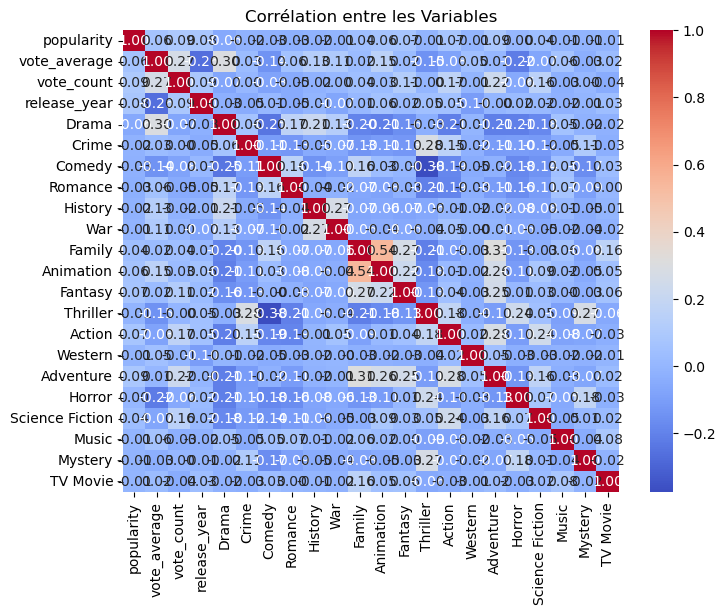

In [94]:
corr_matrix = movies.drop(columns=['id']).corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Corrélation entre les Variables') #demander à chatgpt d'afficher les plus importants pour une colonne
plt.show()

### 6. Nuage de mots pour les genres

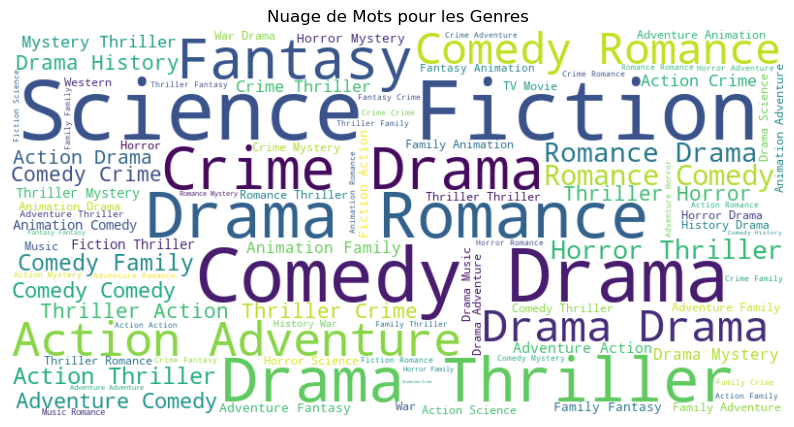

In [103]:
genre_text = ' '.join(movies['genre'].str.split(',').sum())
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(genre_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuage de Mots pour les Genres')
plt.show()

### 8. Distribution des notes (vote_average)

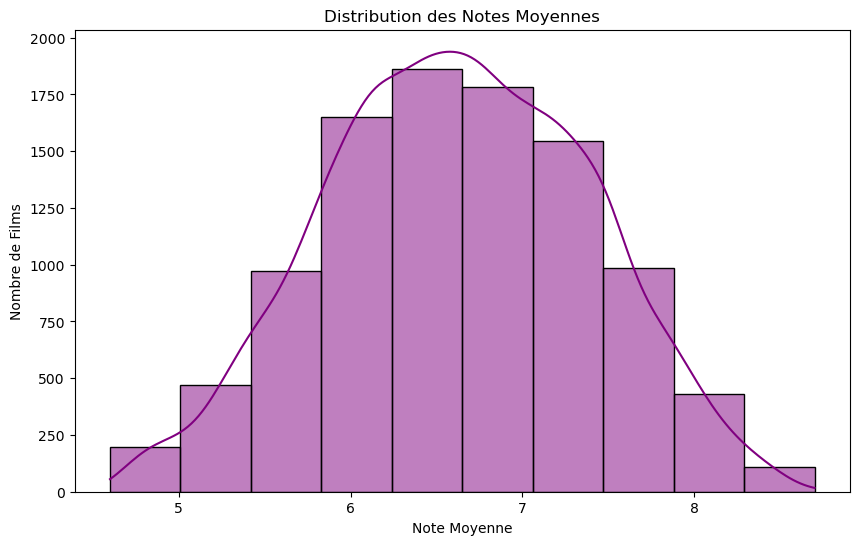

In [106]:
plt.figure(figsize=(10, 6))
sns.histplot(movies['vote_average'], bins=10, kde=True, color='purple')
plt.title('Distribution des Notes Moyennes')
plt.xlabel('Note Moyenne')
plt.ylabel('Nombre de Films')
plt.show()

### 9. Moyenne des votes par genre

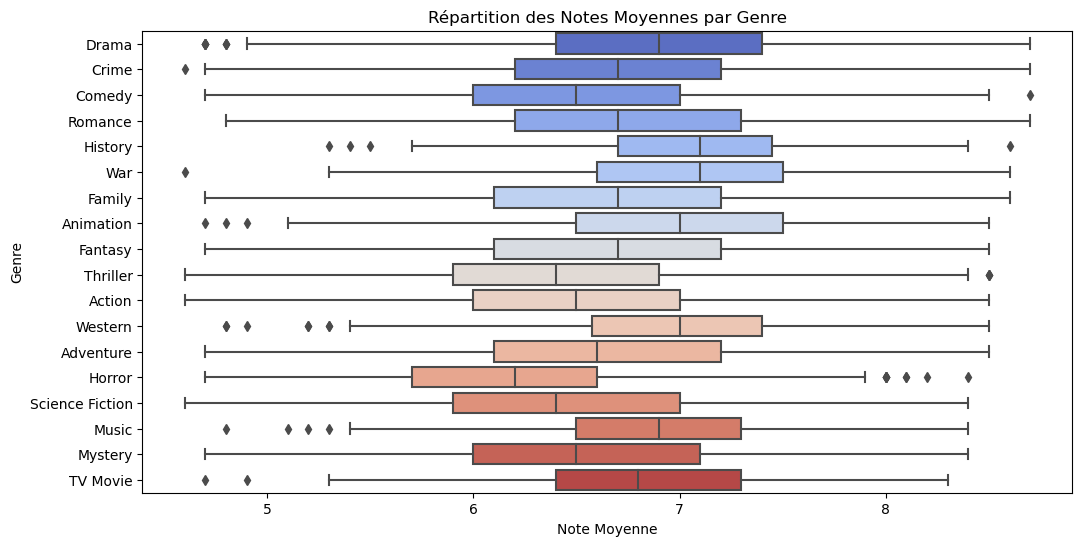

In [108]:
movies_long = movies.melt(id_vars=['vote_average'], var_name='genre', value_name='is_genre')

movies_long = movies_long[movies_long['is_genre'] == 1]

plt.figure(figsize=(12, 6))
sns.boxplot(x='vote_average', y='genre', data=movies_long, palette='coolwarm') #couleur attention en fonction nombre de votant
plt.title('Répartition des Notes Moyennes par Genre')
plt.xlabel('Note Moyenne')
plt.ylabel('Genre')
plt.show()

### 11. Popularité par Genre

In [42]:
movies_long = movies.melt(id_vars=['popularity'], var_name='genre', value_name='is_genre')
movies_long = movies_long[movies_long['is_genre'] == 1]

plt.figure(figsize=(12, 6))
sns.boxplot(x='popularity', y='genre', data=movies_long, palette='Set2')
plt.title('Répartition de la Popularité par Genre')#plotly
plt.xlabel('Popularité')
plt.ylabel('Genre')
plt.show()

ValueError: min() arg is an empty sequence

<Figure size 1200x600 with 0 Axes>

### 13. Nuage de mots basé sur les descriptions (overview)

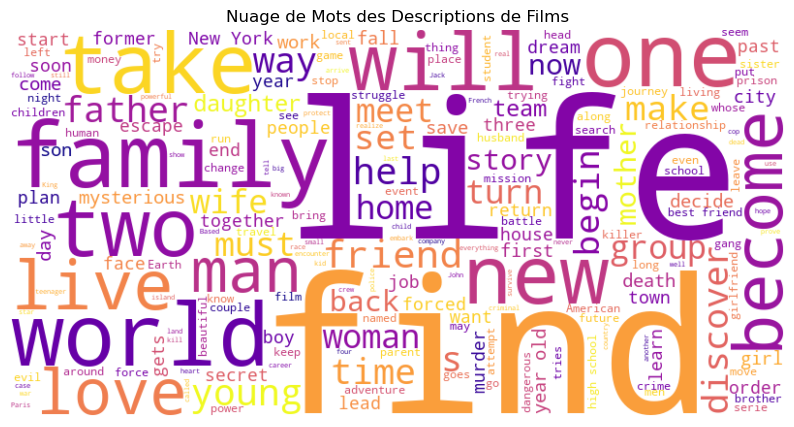

In [115]:
all_overviews = ' '.join(movies['overview'].dropna())

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='plasma').generate(all_overviews)


plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear') #pour plus de 8 et moins dans un autre
plt.axis('off')
plt.title('Nuage de Mots des Descriptions de Films')
plt.show()

### 14. Relation entre popularité et vote_count

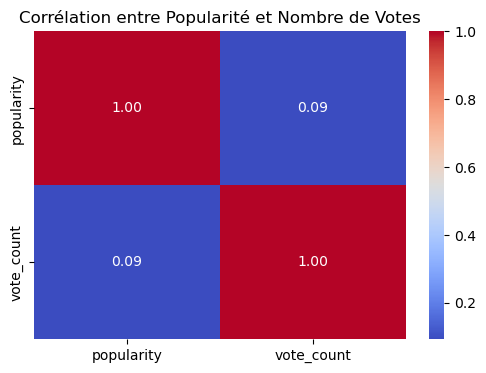

In [116]:
corr_popularity_votes = movies[['popularity', 'vote_count']].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(corr_popularity_votes, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Corrélation entre Popularité et Nombre de Votes')
plt.show()

### 15. Films les plus populaires au fil du temps

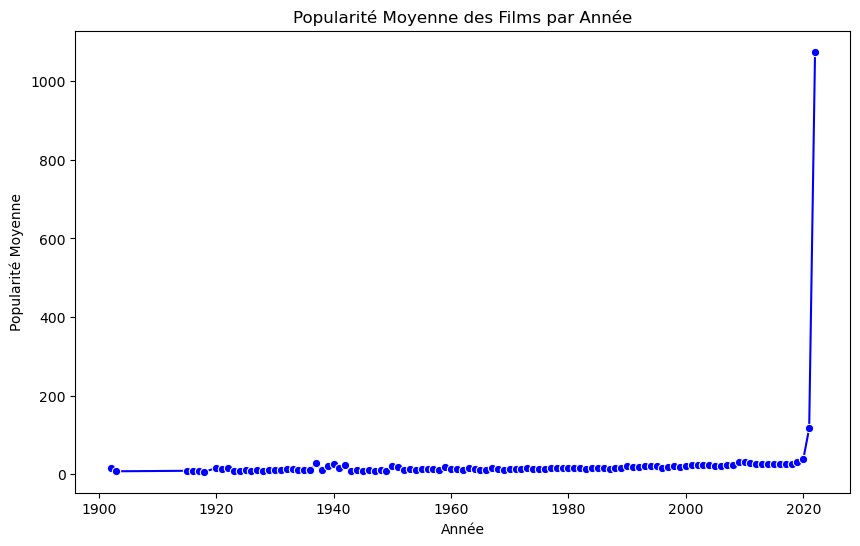

In [117]:
yearly_popularity = movies.groupby('release_year')['popularity'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(x='release_year', y='popularity', data=yearly_popularity, marker='o', color='b')
plt.title('Popularité Moyenne des Films par Année')
plt.xlabel('Année')
plt.ylabel('Popularité Moyenne')
plt.show()

### 16. Films par Langue

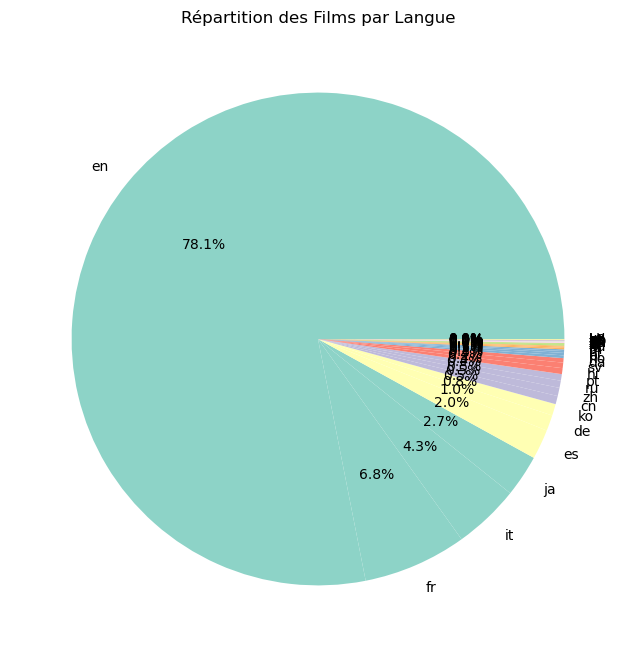

In [118]:
language_counts = movies['original_language'].value_counts()

plt.figure(figsize=(8, 8))
language_counts.plot.pie(autopct='%1.1f%%', cmap='Set3', legend=False)
plt.title('Répartition des Films par Langue')
plt.ylabel('')
plt.show()

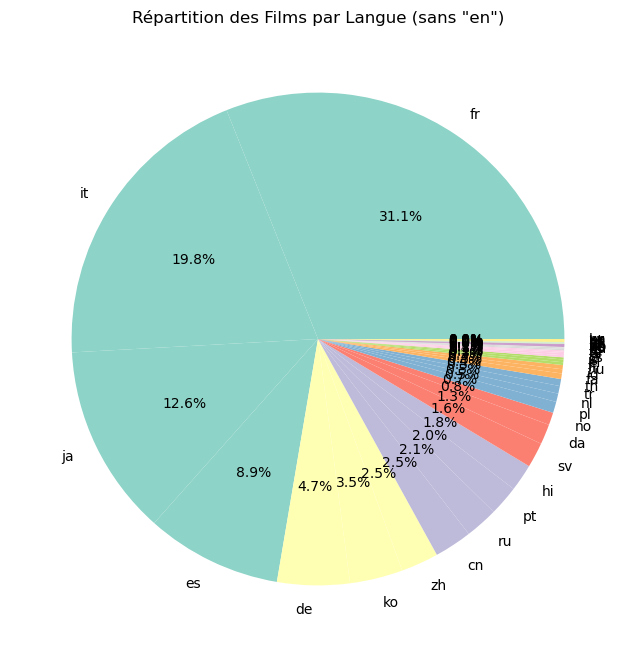

In [119]:
language_counts = movies[movies['original_language'] != 'en']['original_language'].value_counts()

plt.figure(figsize=(8, 8))
language_counts.plot.pie(autopct='%1.1f%%', cmap='Set3', legend=False)
plt.title('Répartition des Films par Langue (sans "en")')
plt.ylabel('')
plt.show()

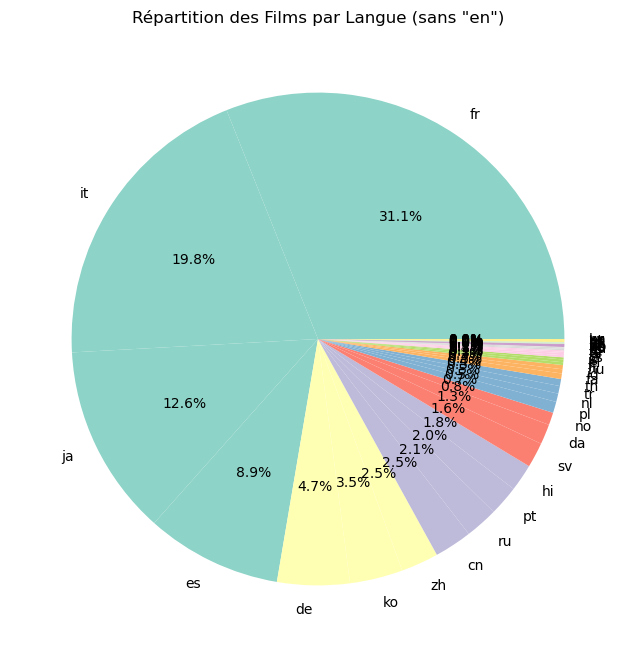

In [120]:
language_to_exclude = 'en' 

language_counts = movies[movies['original_language'] != language_to_exclude]['original_language'].value_counts()

plt.figure(figsize=(8, 8))
language_counts.plot.pie(autopct='%1.1f%%', cmap='Set3', legend=False)
plt.title(f'Répartition des Films par Langue (sans "{language_to_exclude}")')
plt.ylabel('')
plt.show()

### 17. Distribution de la longueur des descriptions

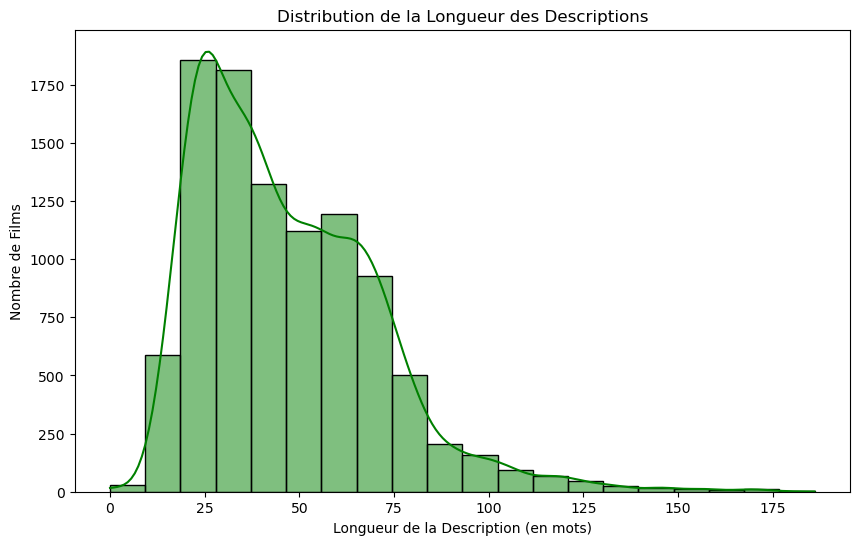

In [128]:
movies['overview_length'] = movies['overview'].apply(lambda x: len(str(x).split()) if pd.notna(x) else 0)

plt.figure(figsize=(10, 6))
sns.histplot(movies['overview_length'], bins=20, kde=True, color='green')
plt.title('Distribution de la Longueur des Descriptions') #ajouter group by pour tres mauvais films, moyen, bien et tb
plt.xlabel('Longueur de la Description (en mots)')
plt.ylabel('Nombre de Films')
plt.show()

### 18. Distribution des films par genre et langue

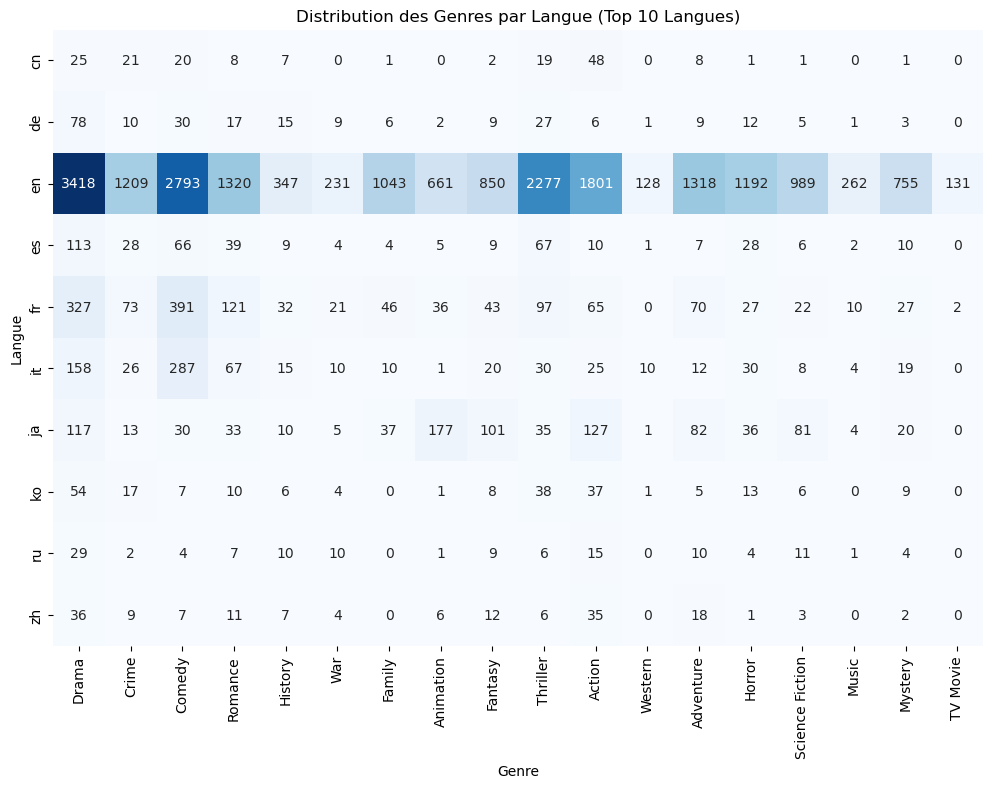

In [133]:
film_counts_by_language = movies['original_language'].value_counts()

top_10_languages = film_counts_by_language.head(10).index

filtered_movies = movies[movies['original_language'].isin(top_10_languages)]

genre_language_counts = filtered_movies.groupby('original_language')[['Drama', 'Crime', 'Comedy', 'Romance', 'History', 'War', 'Family',
                                                                   'Animation', 'Fantasy', 'Thriller', 'Action', 'Western',
                                                                   'Adventure', 'Horror', 'Science Fiction', 'Music', 'Mystery', 'TV Movie']].sum()

genre_language_counts = genre_language_counts.astype(int)

plt.figure(figsize=(12, 8))
sns.heatmap(genre_language_counts, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.title('Distribution des Genres par Langue (Top 10 Langues)')
plt.xlabel('Genre')
plt.ylabel('Langue')
plt.show()

## Step 3: Correlation Analysis

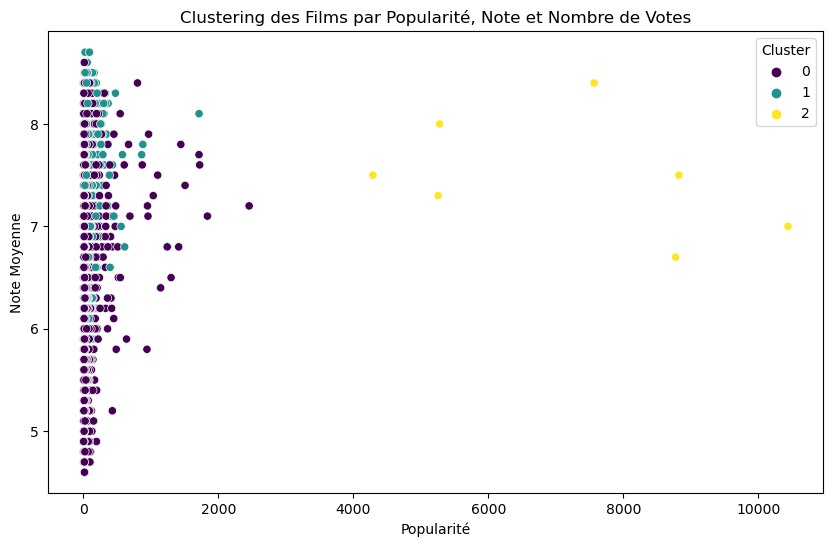

In [138]:
features = movies[['popularity', 'vote_average', 'vote_count']].dropna()

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

kmeans = KMeans(n_clusters=3, random_state=42)
movies['cluster'] = kmeans.fit_predict(scaled_features)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='popularity', y='vote_average', hue='cluster', data=movies, palette='viridis')
plt.title('Clustering des Films par Popularité, Note et Nombre de Votes')
plt.xlabel('Popularité')
plt.ylabel('Note Moyenne')
plt.legend(title='Cluster')
plt.show()

## Step 4: Predictive Modeling

### Préparation des données

In [172]:
X = movies.drop(columns=['vote_average', 'title', 'release_date','genre','cluster']) 
y = movies['vote_average']

In [173]:
X.columns

Index(['id', 'original_language', 'overview', 'popularity', 'vote_count',
       'release_year', 'Drama', 'Crime', 'Comedy', 'Romance', 'History', 'War',
       'Family', 'Animation', 'Fantasy', 'Thriller', 'Action', 'Western',
       'Adventure', 'Horror', 'Science Fiction', 'Music', 'Mystery',
       'TV Movie', 'decade', 'overview_length'],
      dtype='object')

In [174]:
X['overview_length']

0       69
1       70
2       48
3       29
4       39
        ..
9995    36
9996    18
9997    61
9998    36
9999    41
Name: overview_length, Length: 10000, dtype: int64

In [175]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 10000 non-null  int64  
 1   original_language  10000 non-null  object 
 2   overview           9987 non-null   object 
 3   popularity         10000 non-null  float64
 4   vote_count         10000 non-null  int64  
 5   release_year       10000 non-null  int64  
 6   Drama              10000 non-null  int64  
 7   Crime              10000 non-null  int64  
 8   Comedy             10000 non-null  int64  
 9   Romance            10000 non-null  int64  
 10  History            10000 non-null  int64  
 11  War                10000 non-null  int64  
 12  Family             10000 non-null  int64  
 13  Animation          10000 non-null  int64  
 14  Fantasy            10000 non-null  int64  
 15  Thriller           10000 non-null  int64  
 16  Action             1000

Transformons la colonne Overview en Vecteur

In [176]:
tfidf = TfidfVectorizer(stop_words='english', max_features=100) 
overview_tfidf = tfidf.fit_transform(movies['overview'].fillna(''))
overview_df = pd.DataFrame(overview_tfidf.toarray(), columns=tfidf.get_feature_names_out())
X = pd.concat([X, overview_df], axis=1)
X = X.drop(columns=['overview'])

In [177]:
X = pd.get_dummies(X, columns=['original_language'], drop_first=True)

In [178]:
X.columns

Index(['id', 'popularity', 'vote_count', 'release_year', 'Drama', 'Crime',
       'Comedy', 'Romance', 'History', 'War',
       ...
       'original_language_ru', 'original_language_sh', 'original_language_sr',
       'original_language_sv', 'original_language_te', 'original_language_th',
       'original_language_tr', 'original_language_uk', 'original_language_xx',
       'original_language_zh'],
      dtype='object', length=166)

In [179]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 166 entries, id to original_language_zh
dtypes: float64(101), int64(23), uint8(42)
memory usage: 9.9 MB


In [180]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Régression Linéaire (sans GridSearch)

Régression linéaire : Un modèle de base pour voir si une relation linéaire simple peut expliquer les notes des films. Si les performances sont faibles, c'est une indication que des modèles plus complexes sont nécessaires.

In [181]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f'Linear Regression - MSE: {mse_lr}, R²: {r2_lr}')

Linear Regression - MSE: 0.31646960823395476, R²: 0.4614577392613799


### Régression Ridge (avec GridSearch)

Ridge et Lasso : Ces modèles de régression régulière vous aident à éviter le sur-apprentissage (overfitting) en pénalisant les coefficients, ce qui est important dans les cas où vous avez beaucoup de variables (genres). Lasso, en particulier, est utile si vous souhaitez réduire certaines variables à zéro.

In [185]:
ridge = Ridge()
param_grid = {'alpha': [0.1, 1, 10, 100]}

grid_search_ridge = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search_ridge.fit(X_train, y_train)

best_ridge = grid_search_ridge.best_estimator_
y_pred_ridge = best_ridge.predict(X_test)

mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print(f'Ridge Regression - Best Alpha: {grid_search_ridge.best_params_["alpha"]}')
print(f'Ridge Regression - MSE: {mse_ridge}, R²: {r2_ridge}')

Ridge Regression - Best Alpha: 10
Ridge Regression - MSE: 0.3111020871593148, R²: 0.47059175042355705


### Régression Lasso (avec GridSearch)

In [187]:
lasso = Lasso()

param_grid_lasso = {'alpha': [0.1, 1, 10, 100]}

grid_search_lasso = GridSearchCV(lasso, param_grid_lasso, cv=5, scoring='neg_mean_squared_error')
grid_search_lasso.fit(X_train, y_train)

best_lasso = grid_search_lasso.best_estimator_
y_pred_lasso = best_lasso.predict(X_test)

mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

print(f'Lasso Regression - Best Alpha: {grid_search_lasso.best_params_["alpha"]}')
print(f'Lasso Regression - MSE: {mse_lasso}, R²: {r2_lasso}')

Lasso Regression - Best Alpha: 0.1
Lasso Regression - MSE: 0.44492302816037704, R²: 0.24286614826208797


### Forêt aléatoire

Random Forest : Ce modèle est puissant pour capturer des relations non linéaires et des interactions complexes entre les caractéristiques. Cependant, il peut nécessiter plus de ressources de calcul et un réglage précis.

In [190]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Entraînement du modèle
rf.fit(X_train, y_train)

# Prédictions
y_pred_rf = rf.predict(X_test)

# Évaluation
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f'Random Forest - MSE: {mse_rf}, R²: {r2_rf}')

Random Forest - MSE: 0.27895580700000006, R²: 0.5252956775650732


### Gradient Boosting Machines

In [193]:
gbm = GradientBoostingRegressor(random_state=42)

gbm.fit(X_train, y_train)

y_pred_gbm = gbm.predict(X_test)

mse_gbm = mean_squared_error(y_test, y_pred_gbm)
r2_gbm = r2_score(y_test, y_pred_gbm)

print(f"Gradient Boosting - MSE: {mse_gbm:.4f}, R²: {r2_gbm:.4f}")

Gradient Boosting - MSE: 0.2810, R²: 0.5219


### XGBoost

In [195]:
xgb = XGBRegressor(random_state=42)

xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost - MSE: {mse_xgb:.4f}, R²: {r2_xgb:.4f}")

XGBoost - MSE: 0.2755, R²: 0.5311


### LightGBM

In [200]:
lgbm = LGBMRegressor(random_state=42)

lgbm.fit(X_train, y_train)

y_pred_lgbm = lgbm.predict(X_test)

mse_lgbm = mean_squared_error(y_test, y_pred_lgbm)
r2_lgbm = r2_score(y_test, y_pred_lgbm)

print(f"LightGBM - MSE: {mse_lgbm:.4f}, R²: {r2_lgbm:.4f}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11668
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 138
[LightGBM] [Info] Start training from score 6.616775
LightGBM - MSE: 0.2574, R²: 0.5619


### Comparaison des modèles

In [201]:
print(f"Linear Regression - MSE: {mse_lr:.4f}, R²: {r2_lr:.4f}")
print(f"Ridge Regression - MSE: {mse_ridge:.4f}, R²: {r2_ridge:.4f}")
print(f"Lasso Regression - MSE: {mse_lasso:.4f}, R²: {r2_lasso:.4f}")
print(f"Random Forest Regression - MSE: {mse_rf:.4f}, R²: {r2_rf:.4f}")
print(f"Gradient Boosting - MSE: {mse_gbm:.4f}, R²: {r2_gbm:.4f}")
print(f"XGBoost - MSE: {mse_xgb:.4f}, R²: {r2_xgb:.4f}") #tableau
print(f"LightGBM - MSE: {mse_lgbm:.4f}, R²: {r2_lgbm:.4f}")

Linear Regression - MSE: 0.3165, R²: 0.4615
Ridge Regression - MSE: 0.3111, R²: 0.4706
Lasso Regression - MSE: 0.4449, R²: 0.2429
Random Forest Regression - MSE: 0.2790, R²: 0.5253
Gradient Boosting - MSE: 0.2810, R²: 0.5219
XGBoost - MSE: 0.2755, R²: 0.5311
LightGBM - MSE: 0.2574, R²: 0.5619


MSE (Mean Squared Error) :

Plus la valeur est faible, meilleure est la précision des prédictions.
Random Forest a le plus faible MSE (0.279), ce qui indique qu'il est le meilleur modèle pour minimiser les erreurs de prédiction.
Lasso Regression a le MSE le plus élevé (0.444), ce qui signifie qu'elle est la moins performante dans ce cas.

R² (Coefficient de Détermination) :

Plus le score R² est proche de 1, meilleure est la capacité du modèle à expliquer la variance dans les données.
Random Forest a le meilleur R² (0.525), signifiant qu'il explique environ 52.5% de la variance des notes.
Lasso Regression a le R² le plus faible (0.243), montrant qu'il explique seulement 24.3% de la variance.

### Conclusion

D'après les résultats obtenus, LightGBM est clairement le meilleur modèle pour prédire la note moyenne des films. Avec un MSE de 0.2574, le plus faible parmi tous les modèles testés, il produit les prédictions les plus précises. Son R² de 0.5619 indique qu'il explique 56.2% de la variance dans les données, ce qui est également la meilleure performance.

XGBoost arrive en deuxième position avec un MSE légèrement supérieur (0.2755) et un R² de 0.5311, le rendant aussi très compétitif.

Random Forest et Gradient Boosting offrent des performances honorables, mais leur MSE et R² sont moins bons que ceux de LightGBM et XGBoost.

Les modèles de régression plus simples (Linear Regression, Ridge, et Lasso) montrent des performances nettement inférieures, soulignant leur limite dans la capture de relations complexes dans les données.

Conclusion :
Le modèle LightGBM est le choix optimal pour ce problème, car il offre la meilleure précision et la capacité explicative la plus élevée. Si des ressources supplémentaires sont disponibles, il est recommandé d’affiner ses hyperparamètres pour maximiser ses performances.

## Recommendation de films

In [10]:
movies1=movies[['id', 'title', 'overview', 'genre']]

In [14]:
movies1.columns

Index(['id', 'title', 'overview', 'genre'], dtype='object')

In [15]:
movies1['tags'] = movies1['overview']+movies1['genre']
new_data  = movies1.drop(columns=['overview', 'genre'])

In [16]:
new_data

id                                          title  \
0        278                       The Shawshank Redemption   
1      19404                    Dilwale Dulhania Le Jayenge   
2        238                                  The Godfather   
3        424                               Schindler's List   
4        240                         The Godfather: Part II   
...      ...                                            ...   
9995   10196                             The Last Airbender   
9996  331446                       Sharknado 3: Oh Hell No!   
9997   13995                                Captain America   
9998    2312  In the Name of the King: A Dungeon Siege Tale   
9999  455957                                         Domino   

                                                   tags  
0     Framed in the 1940s for the double murder of h...  
1     Raj is a rich, carefree, happy-go-lucky second...  
2     Spanning the years 1945 to 1955, a chronicle o...  
3     The true story of how businessman Oskar Schind...  
4     In the continuing saga of the Corleone crime f...  
...                                                 ...  
9995  The story follows the adventures of Aang, a yo...  
9996  The sharks take bite out of the East Coast whe...  
9997  During World War II, a brave, patriotic Americ...  
9998  A man named Farmer sets out to rescue his kidn...  
9999  Seeking justice for his partner’s murder by an...  

[10000 rows x 3 columns]

In [20]:
cv = CountVectorizer(max_features=10000, stop_words='english')

vector=cv.fit_transform(new_data['tags'].values.astype('U')).toarray()

In [21]:
cv

CountVectorizer(max_features=10000, stop_words='english')

In [22]:
vector.shape

(10000, 10000)

In [24]:
similarity=cosine_similarity(vector)

In [25]:
similarity

array([[1.        , 0.05634362, 0.12888482, ..., 0.07559289, 0.11065667,
        0.06388766],
       [0.05634362, 1.        , 0.07624929, ..., 0.        , 0.03636965,
        0.        ],
       [0.12888482, 0.07624929, 1.        , ..., 0.02273314, 0.06655583,
        0.08645856],
       ...,
       [0.07559289, 0.        , 0.02273314, ..., 1.        , 0.03253   ,
        0.02817181],
       [0.11065667, 0.03636965, 0.06655583, ..., 0.03253   , 1.        ,
        0.0412393 ],
       [0.06388766, 0.        , 0.08645856, ..., 0.02817181, 0.0412393 ,
        1.        ]])

On regarde la data (index 1 = nom du film) qui a la distance de similarity la plus proche de film qui a comme id = 2 donc the godfather (similarity[2]).

In [26]:
distance = sorted(list(enumerate(similarity[2])), reverse=True, key=lambda vector:vector[1])
for i in distance[0:5]:
    print(new_data.iloc[i[0]].title)

The Godfather
The Godfather: Part II
Blood Ties
Joker
Bomb City


Maintenant on fait la meme mais avec une fonction pour tout les autres films

In [27]:
def recommand(movies):
    index=new_data[new_data['title']==movies].index[0]
    distance = sorted(list(enumerate(similarity[index])), reverse=True, key=lambda vector:vector[1])
    for i in distance[0:5]:
        print(new_data.iloc[i[0]].title)

In [28]:
recommand("Iron Man")

Iron Man
Iron Man 3
Guardians of the Galaxy Vol. 2
Avengers: Age of Ultron
Star Wars: Episode III - Revenge of the Sith


### Pickle

In [30]:
pickle.dump(new_data, open('movies_list.pkl', 'wb'))

In [31]:
pickle.dump(similarity, open('similarity.pkl', 'wb'))

In [32]:
pickle.load(open('movies_list.pkl', 'rb'))

id                                          title  \
0        278                       The Shawshank Redemption   
1      19404                    Dilwale Dulhania Le Jayenge   
2        238                                  The Godfather   
3        424                               Schindler's List   
4        240                         The Godfather: Part II   
...      ...                                            ...   
9995   10196                             The Last Airbender   
9996  331446                       Sharknado 3: Oh Hell No!   
9997   13995                                Captain America   
9998    2312  In the Name of the King: A Dungeon Siege Tale   
9999  455957                                         Domino   

                                                   tags  
0     Framed in the 1940s for the double murder of h...  
1     Raj is a rich, carefree, happy-go-lucky second...  
2     Spanning the years 1945 to 1955, a chronicle o...  
3     The true story of how businessman Oskar Schind...  
4     In the continuing saga of the Corleone crime f...  
...                                                 ...  
9995  The story follows the adventures of Aang, a yo...  
9996  The sharks take bite out of the East Coast whe...  
9997  During World War II, a brave, patriotic Americ...  
9998  A man named Farmer sets out to rescue his kidn...  
9999  Seeking justice for his partner’s murder by an...  

[10000 rows x 3 columns]

In [33]:
pickle.load(open('similarity.pkl', 'rb'))

array([[1.        , 0.05634362, 0.12888482, ..., 0.07559289, 0.11065667,
        0.06388766],
       [0.05634362, 1.        , 0.07624929, ..., 0.        , 0.03636965,
        0.        ],
       [0.12888482, 0.07624929, 1.        , ..., 0.02273314, 0.06655583,
        0.08645856],
       ...,
       [0.07559289, 0.        , 0.02273314, ..., 1.        , 0.03253   ,
        0.02817181],
       [0.11065667, 0.03636965, 0.06655583, ..., 0.03253   , 1.        ,
        0.0412393 ],
       [0.06388766, 0.        , 0.08645856, ..., 0.02817181, 0.0412393 ,
        1.        ]])